In [ ]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt


import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

ModuleNotFoundError: KerasCV uses TensorFlow for its preprocessing layers. While this dependency will be dropped in the future, please install TensorFlow with `pip install tensorflow` to use KerasCV

In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'     
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

In [4]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (256, 256)
    BATCH_SIZE:          int = 16
    NUM_CLASSES:         int = 12
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.2

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL:           str = "resnet50_v2_imagenet"
    EPOCHS:          int = 2
    LEARNING_RATE: float = 1e-4
    CKPT_DIR:        str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]), 
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
    LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])

In [6]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [ ]:

DATASET_DIR = "F:\\projects\\final year\\datasets\\train\\HS"

# Search for images and masks inside all Tile folders
data_images = glob.glob(os.path.join(DATASET_DIR, "images", "*.tif"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "masks", "*.tif"))

# Sort to maintain alignment between images and masks
data_images.sort()
data_masks.sort()

print(f"Found {len(data_images)} images and {len(data_masks)} masks")
print("Sample image paths:", data_images[:5])
print("Sample mask paths:", data_masks[:5])


Found 865 images and 865 masks
Sample image paths: ['C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\images\\HS15_0.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\images\\HS15_1.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\images\\HS15_10.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\images\\HS15_100.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\images\\HS15_101.tif']
Sample mask paths: ['C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\masks\\HS15_0.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\masks\\HS15_1.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\masks\\HS15_10.tif', 'C:\\Users\\Sankalp Bhirud\\OneDrive\\Desktop\\Wuhan\\Dataset Wuhan\\train\\HS\\masks\\HS15_100.tif', 'C:\\Users\\San

In [8]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))


In [9]:
IMG_SIZE = (256, 256)  # Resize dimensions
NUM_CLASSES = 12  # Set number of segmentation classes

In [10]:
id2color = {
    0: (255, 255, 255),  # Unclassified (#ffffff)
    1: (0, 0, 0),        # Road (#000000)
    2: (255, 211, 127),  # Low Building (#ffd37f)
    3: (255, 0, 0),      # High Building (#ff0000)
    4: (255, 235, 175),  # Arable Land (#FFebAF)
    5: (38, 115, 0),     # Woodland (#267300)
    6: (170, 255, 0),    # Grassland (#aaff00)
    7: (0, 197, 255),    # River (#00c5ff)
    8: (0, 92, 230),     # Lake (#005ce6)
    9: (0, 255, 197),    # Structure (#00ffc5)
    10: (197, 0, 255),   # Excavation (#c500ff)
    11: (178, 178, 178)  # Bare Surface (#B2B2B2)
}

print(id2color)


{0: (255, 255, 255), 1: (0, 0, 0), 2: (255, 211, 127), 3: (255, 0, 0), 4: (255, 235, 175), 5: (38, 115, 0), 6: (170, 255, 0), 7: (0, 197, 255), 8: (0, 92, 230), 9: (0, 255, 197), 10: (197, 0, 255), 11: (178, 178, 178)}


In [11]:
SPLIT_RATIO = 0.10
# Determine the number of validation samples
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [12]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 779
Validation samples: 86


In [13]:
import tensorflow as tf
import numpy as np

# Define a NumPy function for lookup
def numpy_rgb_to_label(mask):
    """ Convert RGB mask from NumPy array to class indices. """
    # Define the mapping from RGB values to class labels
    COLOR_MAP = {
    (255, 255, 255): 0,  # Unclassified
    (0, 0, 0): 1,        # Road
    (255, 211, 127): 2,  # Low Building
    (255, 0, 0): 3,      # High Building
    (255, 235, 175): 4,  # Arable Land
    (38, 115, 0): 5,     # Woodland
    (170, 255, 0): 6,    # Grassland
    (0, 197, 255): 7,    # River
    (0, 92, 230): 8,     # Lake
    (0, 255, 197): 9,    # Structure
    (197, 0, 255): 10,   # Excavation
    (178, 178, 178): 11  # Bare Surface
}

    # **Fix:** Ensure mask is properly decoded as a NumPy array
    mask = np.array(mask)  # Convert TensorFlow tensor to NumPy

    # **Fix:** Ensure mask has the right shape
    if len(mask.shape) == 3 and mask.shape[-1] == 3:  # Ensure RGB shape
        height, width, _ = mask.shape
        label_mask = np.zeros((height, width), dtype=np.uint8)

        # Map each pixel to a class index
        for rgb, class_id in COLOR_MAP.items():
            mask_match = np.all(mask == rgb, axis=-1)  # Check if pixel matches RGB value
            label_mask[mask_match] = class_id

        return label_mask.astype(np.uint8)  # Ensure correct dtype
    else:
        raise ValueError(f"Unexpected mask shape: {mask.shape}")

# Use `tf.py_function()` with explicit shape and dtype
def rgb_to_label(mask):
    """ Wrapper function to apply NumPy-based RGB-to-label conversion inside a TensorFlow graph. """
    
    # **Fix:** Ensure mask has expected shape before applying `tf.py_function`
    mask.set_shape([None, None, 3])  # Expecting (height, width, 3)

    label_mask = tf.py_function(numpy_rgb_to_label, [mask], Tout=tf.uint8)

    # **Fix:** Explicitly set the output tensor shape
    label_mask.set_shape([IMG_SIZE[0], IMG_SIZE[1]])  

    return label_mask

In [14]:
import tensorflow as tf
from PIL import Image
import numpy as np

IMG_SIZE = (256, 256)
NUM_CLASSES = 12

def decode_tif_image(filename):
    """Loads a .tif image and ensures a fixed shape."""
    try:
        img = Image.open(filename.numpy().decode("utf-8"))
        img = img.convert("RGB")
        img = img.resize(IMG_SIZE)
        img = np.array(img, dtype=np.uint8)
        return img
    except Exception as e:
        print(f"Error loading image {filename}: {e}")
        return np.zeros((*IMG_SIZE, 3), dtype=np.uint8)  # Return blank image

def decode_tif_mask(filename):
    """Loads a .tif mask and ensures a fixed shape."""
    try:
        mask = Image.open(filename.numpy().decode("utf-8"))
        mask = mask.convert("L")  # Convert to grayscale
        mask = mask.resize(IMG_SIZE, Image.NEAREST)
        mask = np.array(mask, dtype=np.uint8)
        return mask
    except Exception as e:
        print(f"Error loading mask {filename}: {e}")
        return np.zeros(IMG_SIZE, dtype=np.uint8)  # Return blank mask

def load_data(image_path, mask_path):
    """Processes images and masks, ensuring defined shapes."""
    image = tf.py_function(func=decode_tif_image, inp=[image_path], Tout=tf.uint8)
    mask = tf.py_function(func=decode_tif_mask, inp=[mask_path], Tout=tf.uint8)

    # Explicitly set shapes
    image.set_shape((*IMG_SIZE, 3))
    mask.set_shape(IMG_SIZE)

    # Normalize image
    image = tf.cast(image, tf.float32) / 255.0

    # Convert mask to one-hot encoding
    mask = tf.one_hot(mask, depth=NUM_CLASSES)

    return image, mask


In [1]:
image_dir = "F:\\projects\\final year\\datasets\\train\\HS\\imgs"
mask_dir = "F:\\projects\\final year\\datasets\\train\\HS\\class"
BATCH_SIZE = 16  # Ensure this is defined

# Check if paths exist
if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
    raise FileNotFoundError("Dataset directories not found!")

# Create dataset
dataset = tf.data.Dataset.list_files(os.path.join(image_dir, "*.tif"))
maskset = tf.data.Dataset.list_files(os.path.join(mask_dir, "*.tif"))

dataset = tf.data.Dataset.zip((dataset, maskset))  # Zip image & mask datasets
dataset = dataset.map(lambda img, mask: load_data(img, mask), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


NameError: name 'os' is not defined

In [16]:
dataset = dataset.map(lambda img, mask: load_data(img, mask), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [17]:
train_ds = train_data.map(load_data)

In [18]:
tf.keras.backend.clear_session()  # Clear any existing session



In [19]:
print(f"Train data samples: {train_data.cardinality().numpy()}")
print(f"Validation data samples: {valid_data.cardinality().numpy()}")


Train data samples: 779
Validation data samples: 86


In [20]:
# Initialize lookup table
tf.compat.v1.initialize_all_tables()

# Define dataset pipeline
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)


Instructions for updating:
Use `tf.tables_initializer` instead.


In [21]:
train_dataset = (
    train_ds.shuffle(data_config.BATCH_SIZE)
    .batch(data_config.BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
    valid_ds.batch(data_config.BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [22]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(
    preset=train_config.MODEL,
    input_shape=data_config.IMAGE_SIZE + (3,),
    load_weights=True
)

In [23]:
model = keras_cv.models.segmentation.DeepLabV3Plus(
    num_classes=NUM_CLASSES, backbone=backbone,
)

In [24]:
from tensorflow.keras.metrics import Precision, Recall

In [25]:
from keras import backend as K
from tensorflow.keras.backend import flatten as K_flatten
from tensorflow.keras.backend import sum as K_sum

In [26]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K_flatten(y_true)
  y_pred_flatten = K_flatten(y_pred)
  intersection = K_sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K_sum(y_true_flatten) + K_sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [27]:
# Compile model with categorical loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics = ["accuracy", jaccard_coef,Precision(),Recall()]
)


In [28]:
# Visualization function for 6-class segmentation
def num_to_rgb(num_arr, color_map):
    output = np.zeros(num_arr.shape[:2] + (3,))
    for k in color_map.keys():
        mask_condition = num_arr == k
        if np.any(mask_condition):
            print(f"Applying color {color_map[k]} for class {k}")
        output[mask_condition] = color_map[k]
    return output.astype(np.uint8)

In [29]:
def get_callbacks(
    train_config,
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    save_best_only=True,
):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )

    checkpoint_filepath = train_config.CKPT_DIR
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

In [30]:
# Build model.
# Get callbacks.
callbacks = get_callbacks(train_config)


In [31]:
model.build(input_shape=(None, 256, 256, 3))

In [32]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/2


C:\Users\Sankalp Bhirud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
C:\Users\Sankalp Bhirud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend\tensorflow\nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.0978 - jaccard_coef: 0.0093 - loss: 0.1138 - precision: 0.1334 - recall: 0.0393 
Epoch 1: val_loss improved from inf to 0.07661, saving model to checkpoints_resnet50_v2\deeplabv3_plus_resnet50_v2.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 530s 10s/step - accuracy: 0.0983 - jaccard_coef: 0.0094 - loss: 0.1136 - precision: 0.1365 - recall: 0.0399 - val_accuracy: 0.3407 - val_jaccard_coef: 0.0176 - val_loss: 0.0766 - val_precision: 0.0240 - val_recall: 0.0806
Epoch 2/2
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2000 - jaccard_coef: 0.0174 - loss: 0.0768 - precision: 0.6798 - recall: 0.2007
Epoch 2: val_loss did not improve from 0.07661
49/49 ━━━━━━━━━━━━━━━━━━━━ 497s 10s/step - accuracy: 0.2000 - jaccard_coef: 0.0174 - loss: 0.0768 - precision: 0.6798 - recall: 0.2013 - val_accuracy: 0.0000e+00 - val_jaccard_coef: 0.0038 - val_loss: 0.1549 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


In [33]:
evaluate = model.evaluate(valid_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0000e+00 - jaccard_coef: 0.0031 - loss: 0.1410 - precision: 0.0000e+00 - recall: 0.0000e+00


In [34]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask
        
    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    
    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)
    
    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
            
        else:
            axis.imshow(data_list[idx])
            
        axis.axis('off')
        
    plt.show()

In [35]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [36]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)
        
        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().argmax(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break
            

In [37]:
def unpackage_inputs(image,mask):
    return image,mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


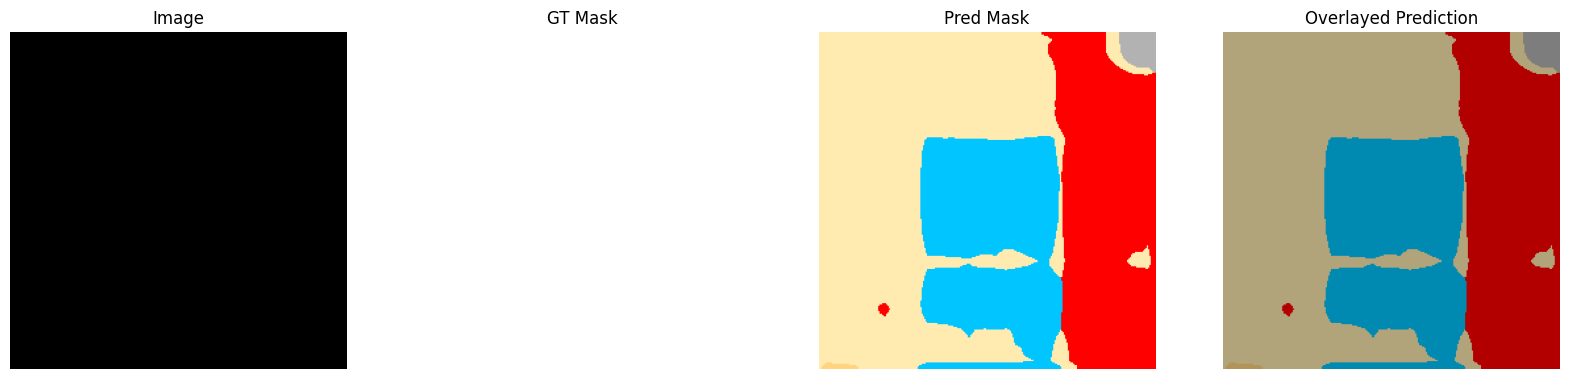

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


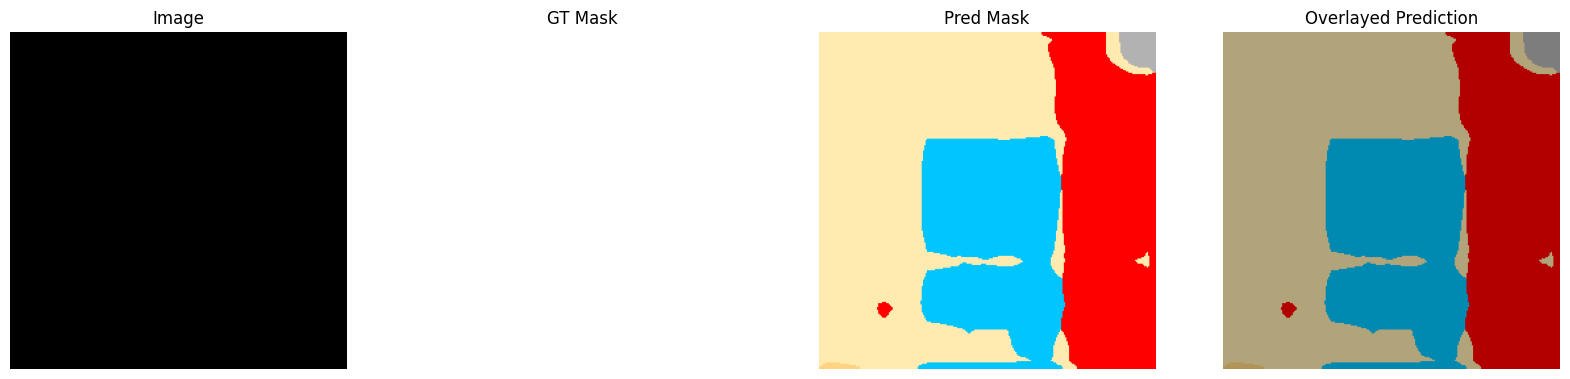

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


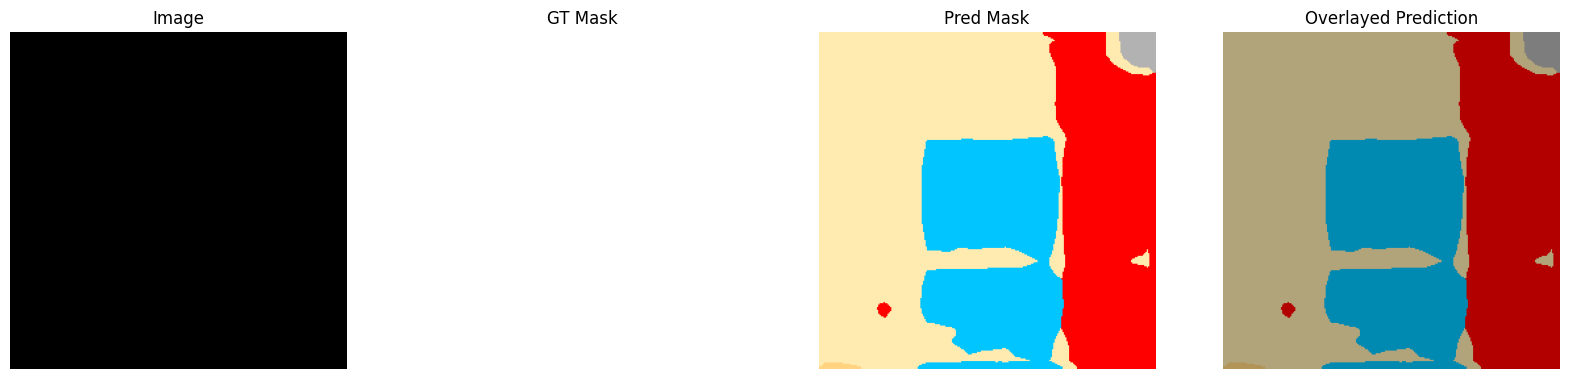

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


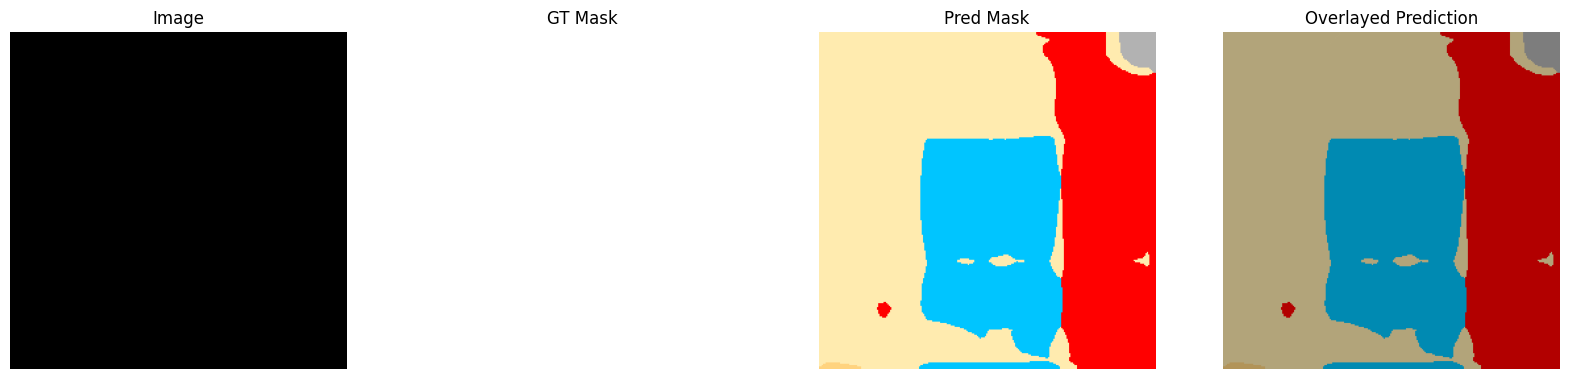

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


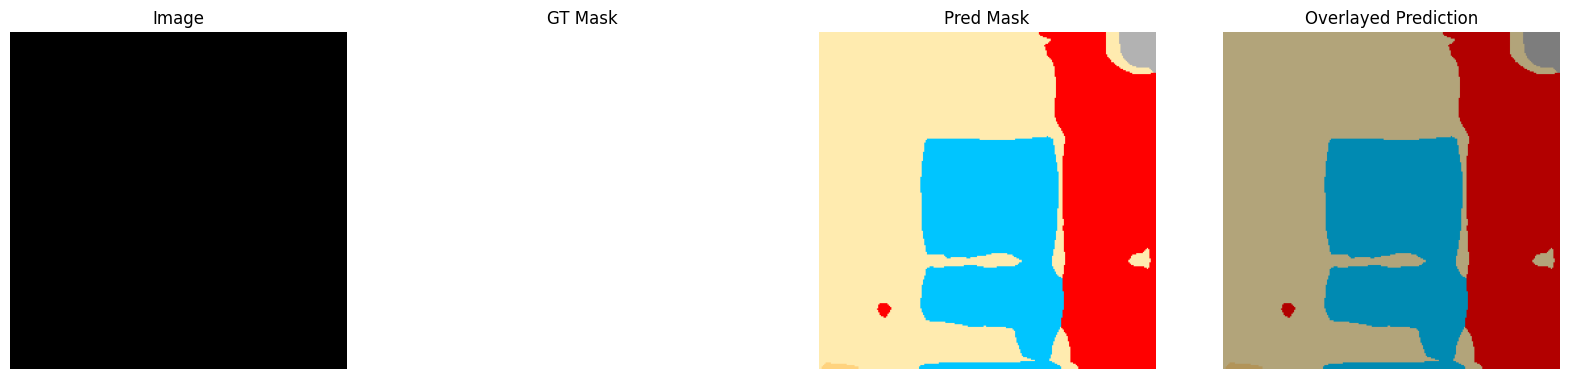

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


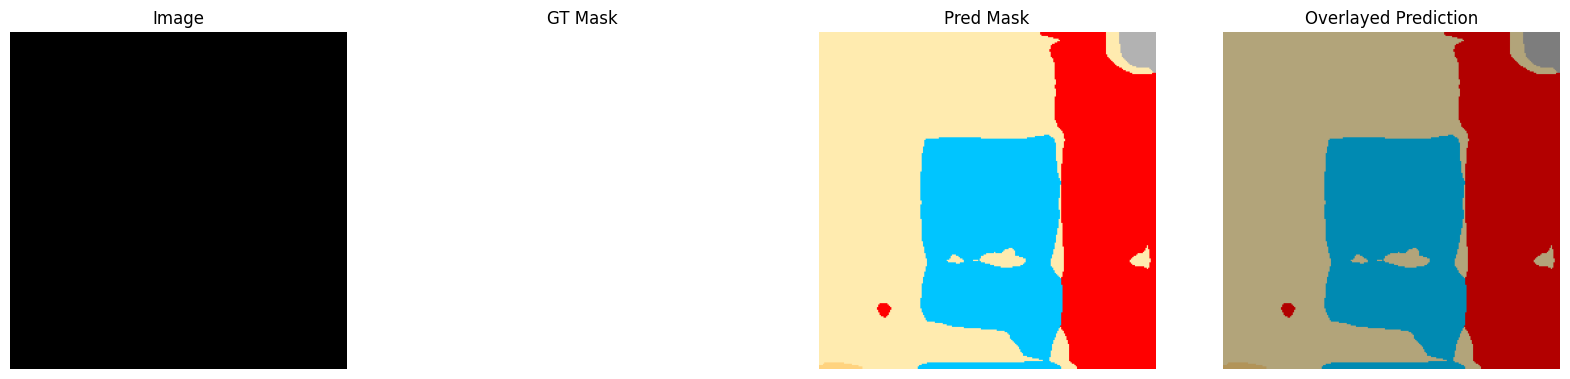

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


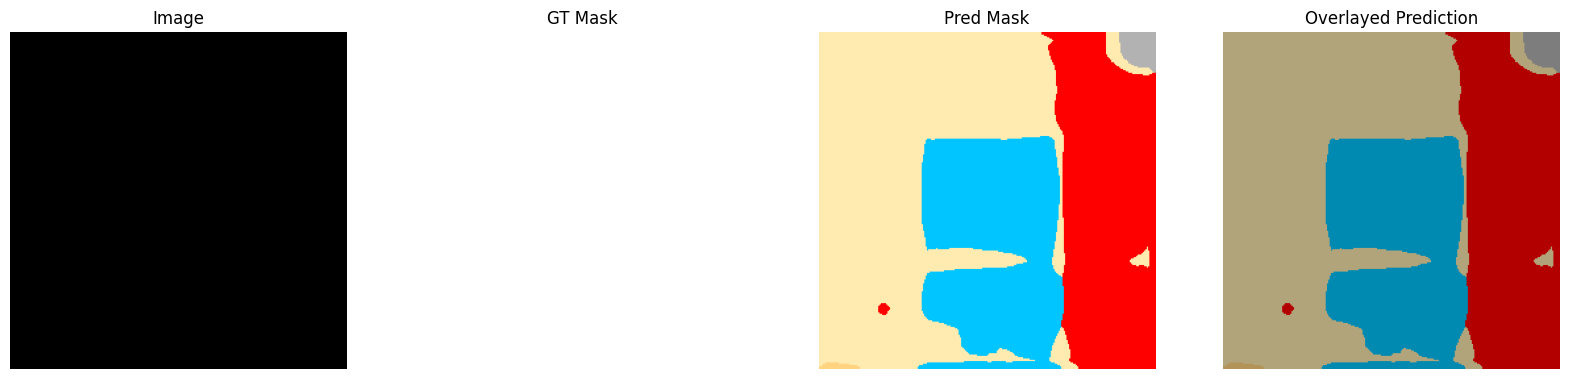

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


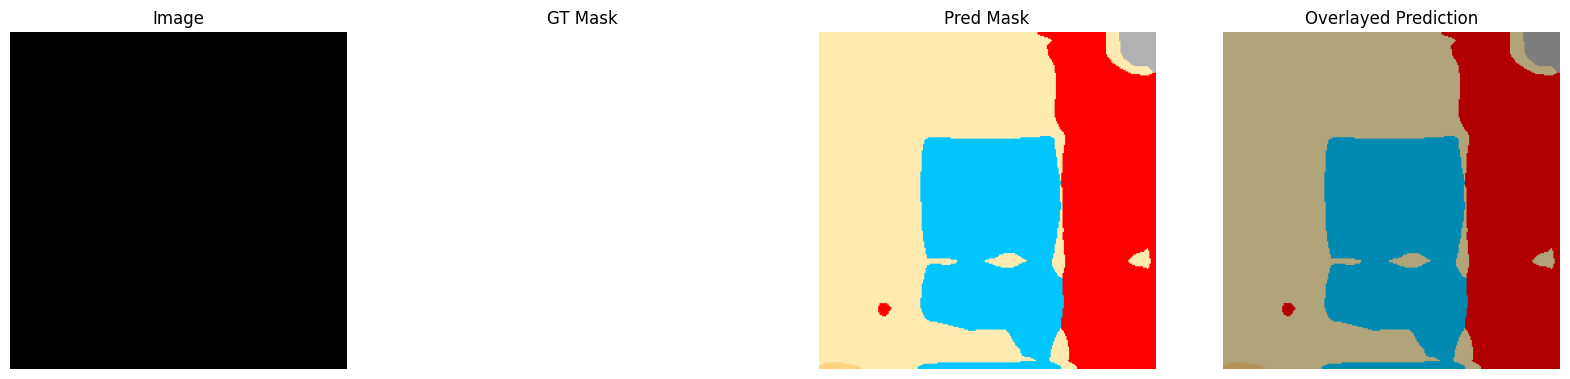

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


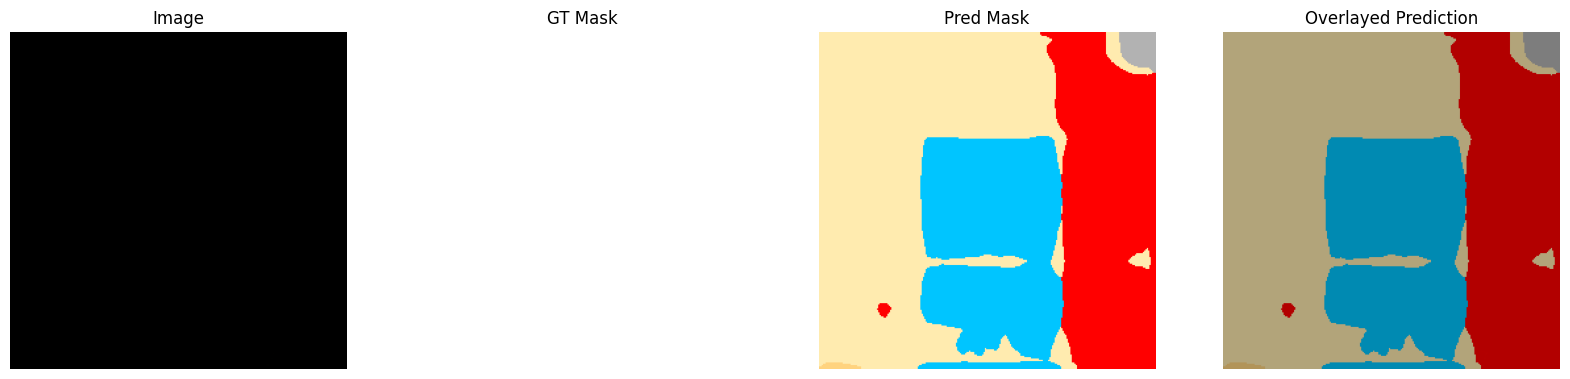

Applying color (255, 255, 255) for class 0
Applying color (255, 211, 127) for class 2
Applying color (255, 0, 0) for class 3
Applying color (255, 235, 175) for class 4
Applying color (0, 197, 255) for class 7
Applying color (178, 178, 178) for class 11


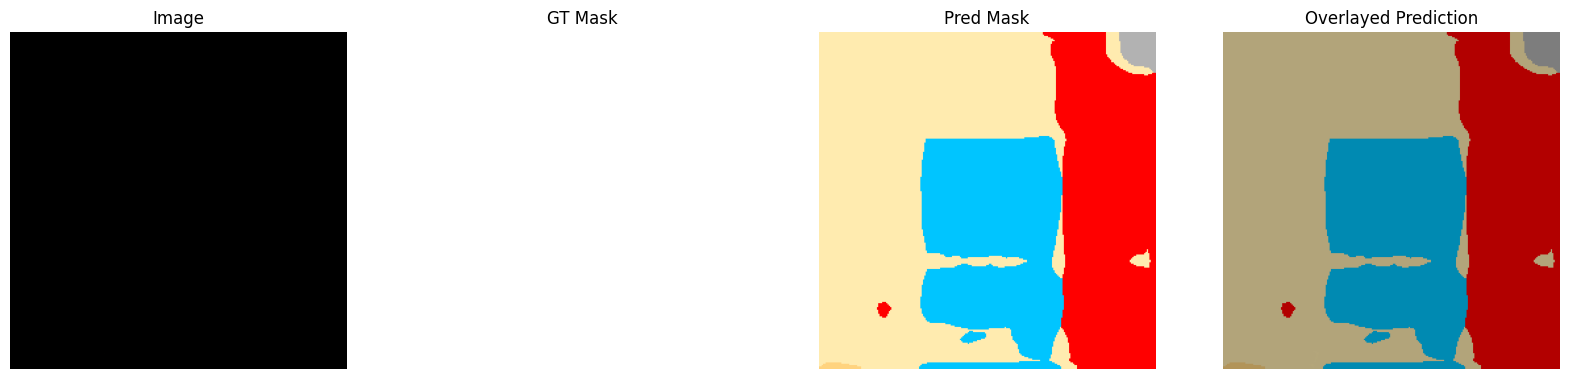

In [38]:
inference(model, valid_dataset, samples_to_plot=10)

In [39]:
evaluate = model.evaluate(valid_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.0000e+00 - jaccard_coef: 0.0031 - loss: 0.1410 - precision: 0.0000e+00 - recall: 0.0000e+00


In [40]:
history_a = history
history_a.history

{'accuracy': [0.12344267964363098, 0.20366248488426208],
 'jaccard_coef': [0.011688592843711376, 0.018424469977617264],
 'loss': [0.10412135720252991, 0.07648943364620209],
 'precision': [0.28669223189353943, 0.6796115636825562],
 'recall': [0.06823030859231949, 0.23026877641677856],
 'val_accuracy': [0.34065744280815125, 0.0],
 'val_jaccard_coef': [0.01762046106159687, 0.00376872974447906],
 'val_loss': [0.07661449909210205, 0.15490388870239258],
 'val_precision': [0.023980360478162766, 0.0],
 'val_recall': [0.08061426132917404, 0.0]}

In [41]:
for images, masks in valid_dataset.take(1):
    print("Validation Image Shape:", images.shape)
    print("Validation Mask Shape:", masks.shape)
    print("Unique Mask Values:", np.unique(masks.numpy()))


Validation Image Shape: (16, 256, 256, 3)
Validation Mask Shape: (16, 256, 256, 12)
Unique Mask Values: [0. 1.]


In [42]:
precision = history_a.history['precision']
recall = history_a.history['recall']

In [43]:
f1_score = 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + 1e-7)
print(f1_score)

[0.1102274  0.34398656]


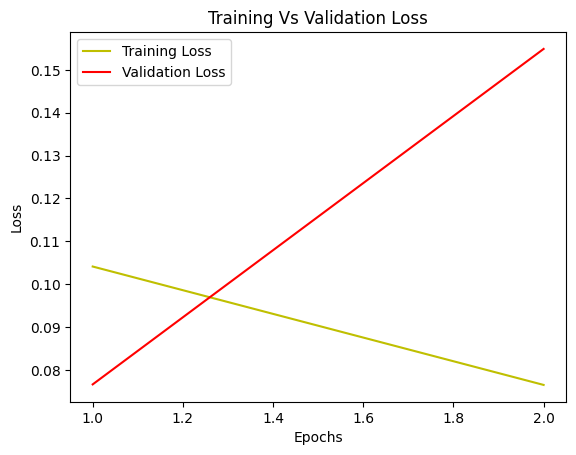

In [44]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

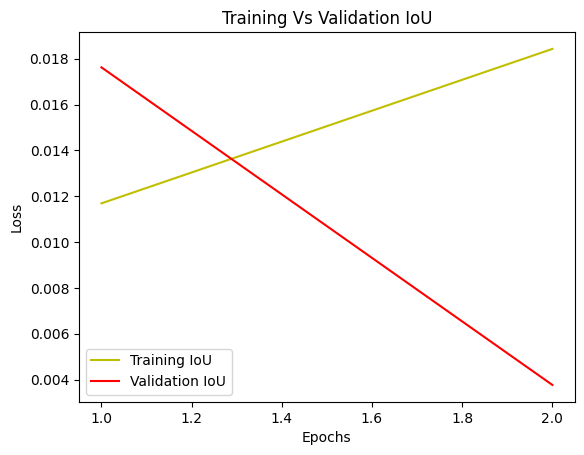

In [45]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

